In [1]:
# %load ./rbm.py
import torch


class RBM():

    def __init__(self, num_visible, num_hidden, k, learning_rate=1e-3, momentum_coefficient=0.5, weight_decay=1e-4, use_cuda=True):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.k = k
        self.learning_rate = learning_rate
        self.momentum_coefficient = momentum_coefficient
        self.weight_decay = weight_decay
        self.use_cuda = use_cuda

        self.weights = torch.randn(num_visible, num_hidden) * 0.1
        self.visible_bias = torch.ones(num_visible) * 0.5
        self.hidden_bias = torch.zeros(num_hidden)

        self.weights_momentum = torch.zeros(num_visible, num_hidden)
        self.visible_bias_momentum = torch.zeros(num_visible)
        self.hidden_bias_momentum = torch.zeros(num_hidden)

        if self.use_cuda:
            self.weights = self.weights.cuda()
            self.visible_bias = self.visible_bias.cuda()
            self.hidden_bias = self.hidden_bias.cuda()

            self.weights_momentum = self.weights_momentum.cuda()
            self.visible_bias_momentum = self.visible_bias_momentum.cuda()
            self.hidden_bias_momentum = self.hidden_bias_momentum.cuda()

    def sample_hidden(self, visible_probabilities):
        print(visible_probabilities.shape)
        print(self.weights.shape)
        hidden_activations = torch.matmul(visible_probabilities, self.weights) + self.hidden_bias
        hidden_probabilities = self._sigmoid(hidden_activations)
        return hidden_probabilities

    def sample_visible(self, hidden_probabilities):
        visible_activations = torch.matmul(hidden_probabilities, self.weights.t()) + self.visible_bias
        visible_probabilities = self._sigmoid(visible_activations)
        return visible_probabilities

    def contrastive_divergence(self, input_data):
        # Positive phase
        positive_hidden_probabilities = self.sample_hidden(input_data)
        positive_hidden_activations = (positive_hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()
        positive_associations = torch.matmul(input_data.t(), positive_hidden_activations)

        # Negative phase
        hidden_activations = positive_hidden_activations

        for step in range(self.k):
            visible_probabilities = self.sample_visible(hidden_activations)
            hidden_probabilities = self.sample_hidden(visible_probabilities)
            hidden_activations = (hidden_probabilities >= self._random_probabilities(self.num_hidden)).float()

        negative_visible_probabilities = visible_probabilities
        negative_hidden_probabilities = hidden_probabilities

        negative_associations = torch.matmul(negative_visible_probabilities.t(), negative_hidden_probabilities)

        # Update parameters
        self.weights_momentum *= self.momentum_coefficient
        self.weights_momentum += (positive_associations - negative_associations)

        self.visible_bias_momentum *= self.momentum_coefficient
        self.visible_bias_momentum += torch.sum(input_data - negative_visible_probabilities, dim=0)

        self.hidden_bias_momentum *= self.momentum_coefficient
        self.hidden_bias_momentum += torch.sum(positive_hidden_probabilities - negative_hidden_probabilities, dim=0)

        batch_size = input_data.size(0)

        self.weights += self.weights_momentum * self.learning_rate / batch_size
        self.visible_bias += self.visible_bias_momentum * self.learning_rate / batch_size
        self.hidden_bias += self.hidden_bias_momentum * self.learning_rate / batch_size

        self.weights -= self.weights * self.weight_decay  # L2 weight decay

        # Compute reconstruction error
        error = torch.sum((input_data - negative_visible_probabilities)**2)

        return error

    def _sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))

    def _random_probabilities(self, num):
        random_probabilities = torch.rand(num)

        if self.use_cuda:
            random_probabilities = random_probabilities.cuda()

        return random_probabilities




In [2]:
from PIL import Image
#from IPython.display import display, Image

In [3]:
# %load mnist_example.py
import numpy as np
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms

In [4]:
from IPython import display
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
import redis
import io
import base64

def decoder(img_str):
    return base64.b64encode(img_str).decode('utf-8')

def encoder(img_str):
    return base64.b64decode(img_str.decode('utf-8'))

def fetch_ring_im(ind, redis):
    img_str = redis.get('frame_%05d' % ind)
    enc_str = encoder(img_str)
    img = Image.open(io.BytesIO(enc_str))
    return img

def fetch_tensor_im(ind, redis, t):
    im = fetch_ring_im(ind, redis)
    t = t(im)
    return t.view(3, 720 * 1024)

In [6]:
VISIBLE_UNITS = 720 * 1024
HIDDEN_UNITS = 640
EPOCHS=4
BATCH_SIZE=3
CD_K=2
CUDA=False

In [7]:
from rbm import RBM
rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K, use_cuda=CUDA)
print('RBM Initialized...')

RBM Initialized...


In [7]:
# frame = 0
# ringsize = 10000
r = redis.StrictRedis(host='redis')
t = torchvision.transforms.ToTensor()

In [8]:
last_frame = 5
start_marker = 3500
starting_offset = 9500
step = 2

In [9]:
from livelossplot import PlotLosses
import pandas as pd

In [10]:
liveloss = PlotLosses()
historical_scores = []

In [20]:
with open('./rbm_l_e1.pkl', 'rb') as pf:
    rbm = torch.load(pf)

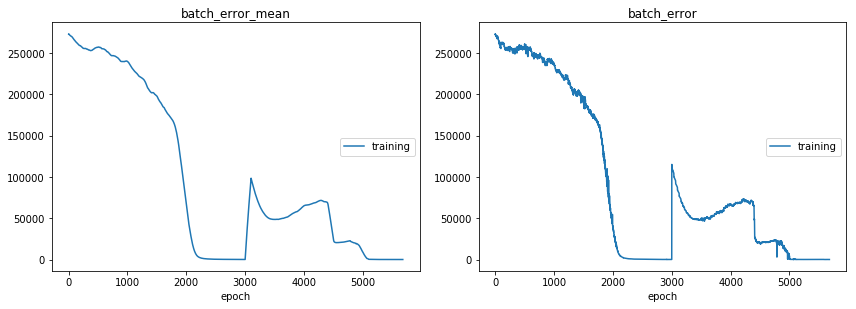

KeyboardInterrupt: 

In [80]:
for epoch in range(EPOCHS):
    epoch_error = 0.0
    for marker in range(start_marker, starting_offset, step):
        tens = fetch_tensor_im(marker, r, t)
        data_loader = torch.utils.data.DataLoader(tens, batch_size=BATCH_SIZE)
        ########## TRAINING RBM ##########
#         print('Training RBM on frame_%05d...' % frame)

        for batch in data_loader:
#         batch = batch.view(len(batch), VISIBLE_UNITS)  # flatten input data

            if CUDA:
                batch = batch.cuda()

            batch_error = rbm.contrastive_divergence(batch)
            historical_scores = historical_scores[-100:]
            historical_scores.append(batch_error)
            
#             epoch_error += batch_error
            batch_error_mean = pd.Series(historical_scores).mean()

            liveloss.update(
                {'batch_error': batch_error, 
                 'batch_error_mean': batch_error_mean})

            liveloss.draw()            
            last_frame = marker

In [223]:
# with open('rbm_l_e2.pkl', 'wb') as rbm_file:
#     torch.save(rbm, rbm_file)

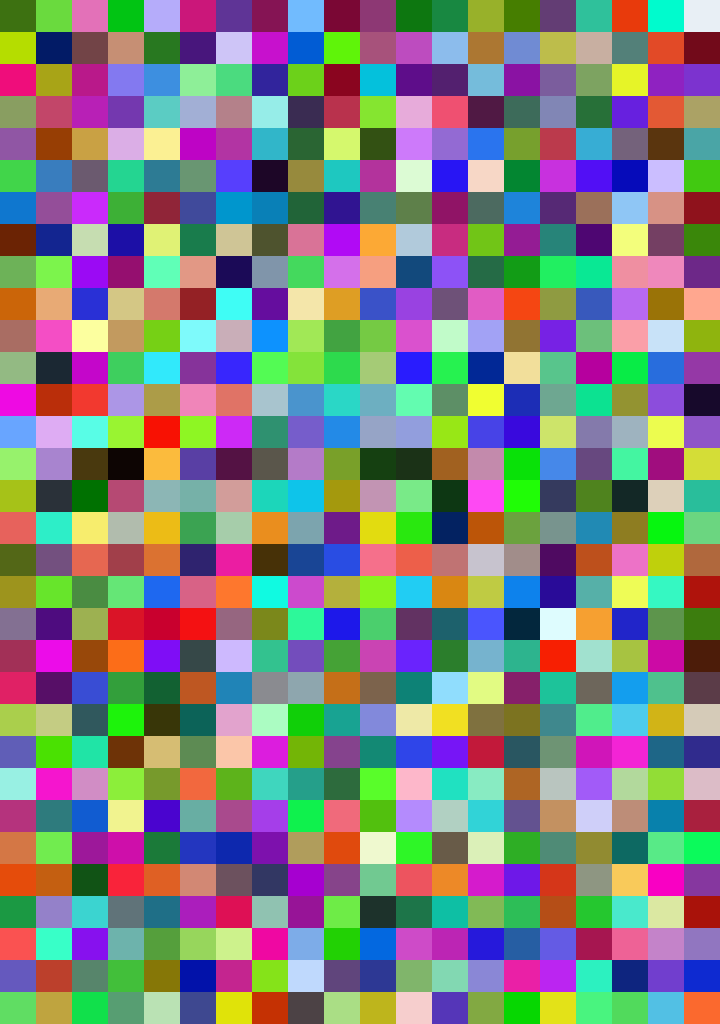

In [21]:
rand_ = torch.randn(3, 640)
proj_t = torch.Tensor(rand_)
stamp_e = torchvision.transforms.ToPILImage()(proj_t.view(3, 32, 20))
stamp_e.resize([720, 1024])

In [22]:
sample = rbm.sample_visible(rand_)
sample


 0.2023  0.2016  0.1888  ...   0.0081  0.0665  0.1316
 0.0174  0.0258  0.0327  ...   0.1449  0.0578  0.0955
 0.6337  0.0430  0.0384  ...   0.1147  0.0896  0.2830
[torch.FloatTensor of size 3x737280]

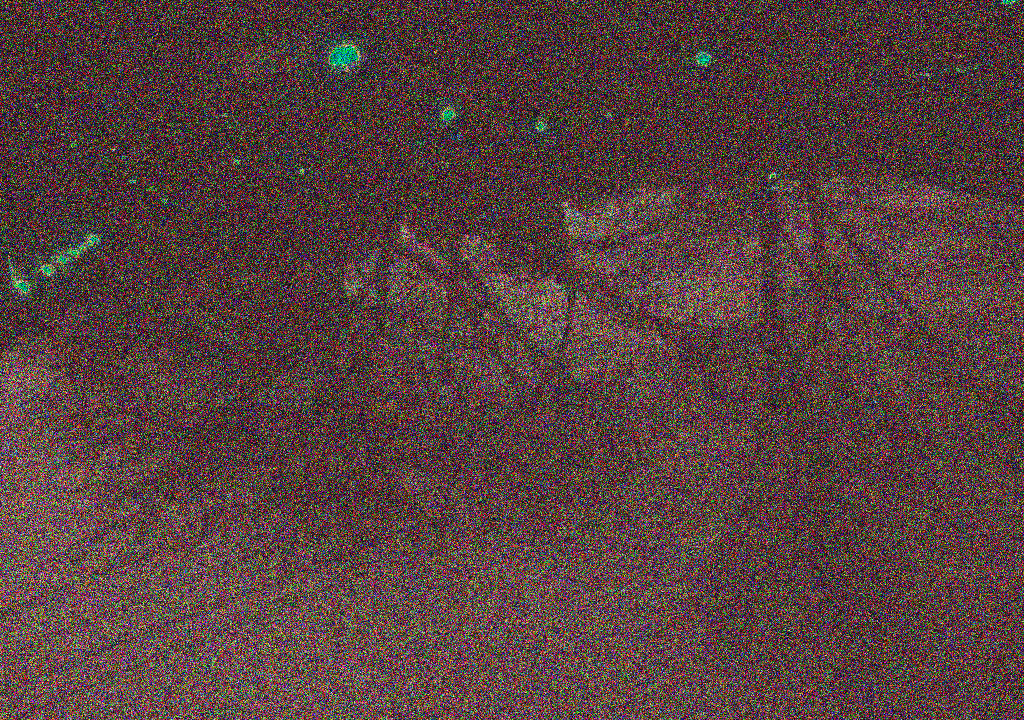

In [23]:
sample = rbm.sample_visible(torch.randn(3, 640))
torchvision.transforms.ToPILImage()(sample.view(3, 720, 1024))

In [16]:
from tqdm import tnrange, tqdm_notebook

In [24]:
for i in tnrange(1440, desc='frames'):
    rand_ = torch.randn(3, 640)
    proj_t = torch.Tensor(rand_)
    p = proj_t
    p[p >= 5] = 1
    p[p < 5] = 0
    proj_t = torch.Tensor(p)
    pp = rbm.sample_visible(proj_t)
    ipp = torchvision.transforms.ToPILImage()(pp.view(3, 720, 1024))
    ipp.save('./image/random/%05i_random_vec.png' % i)

KeyboardInterrupt: 

In [84]:
simply_flattened = fetch_tensor_im(125, r, t)

In [85]:
l = rbm.sample_hidden(simply_flattened)
torchvision.transforms.ToPILImage()(l.view(3, 32, 20))

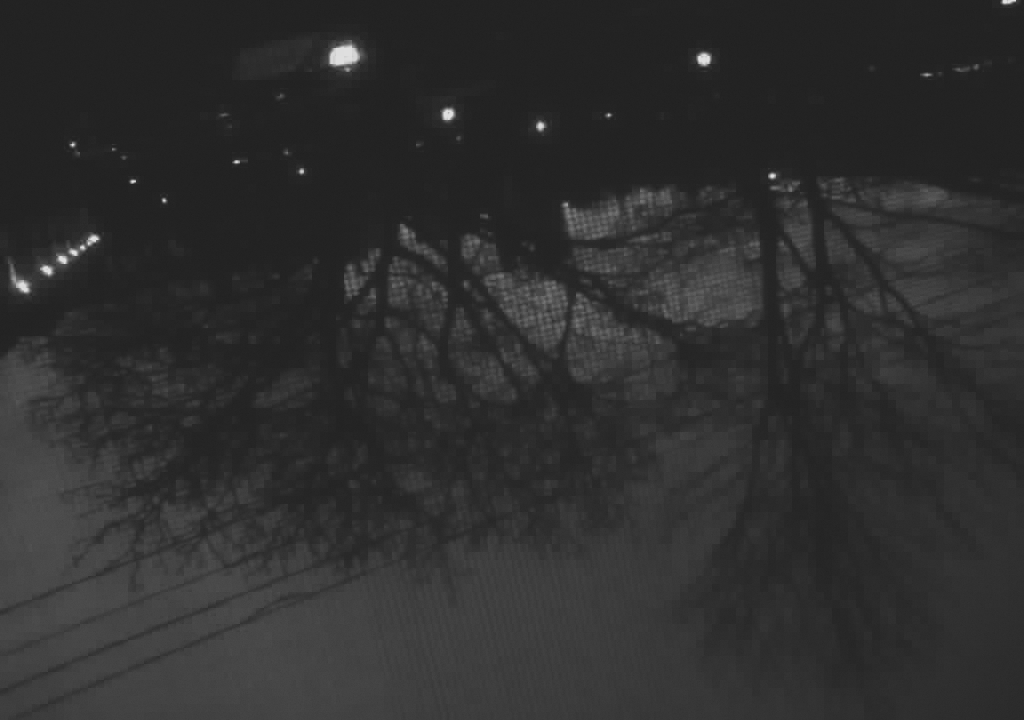

In [86]:
v = rbm.sample_visible(l)
torchvision.transforms.ToPILImage()(v.view(3, 720, 1024))

In [87]:
la = rbm.sample_hidden(simply_flattened)
la_n = la.numpy()
co = np.corrcoef(la_n)

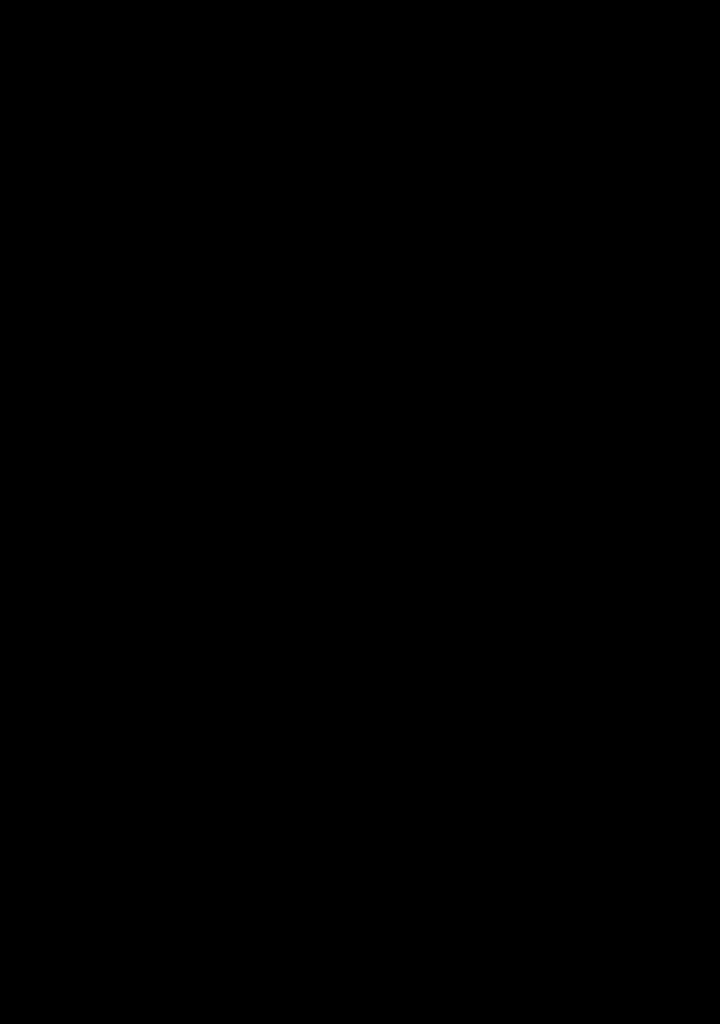

In [88]:
stamp = torchvision.transforms.ToPILImage()(la.view(3, 32, 20))
stamp.resize([720, 1024])

In [89]:
%matplotlib inline

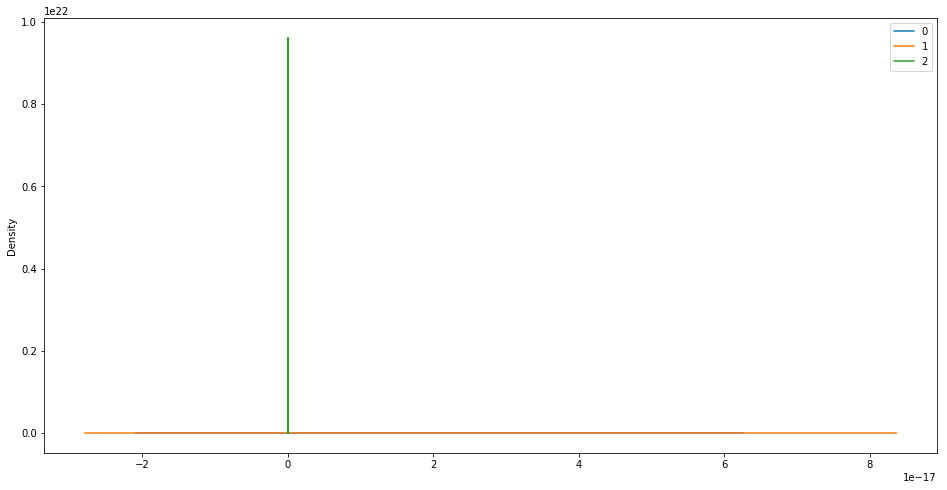

In [91]:
import pandas as pd
df = pd.DataFrame(la_n)
p = df.T.plot.kde(figsize=(16,8))

In [ ]:
# from scipy import stats
# stats.gaussian_kde?

In [ ]:
# kde = stats.gaussian_kde(la_n, )

In [92]:
from sklearn.neighbors import KernelDensity
KernelDensity

sklearn.neighbors.kde.KernelDensity

In [93]:
kde = KernelDensity(
    bandwidth=0.001
).fit(la_n.T)
kde

KernelDensity(algorithm='auto', atol=0, bandwidth=0.001, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

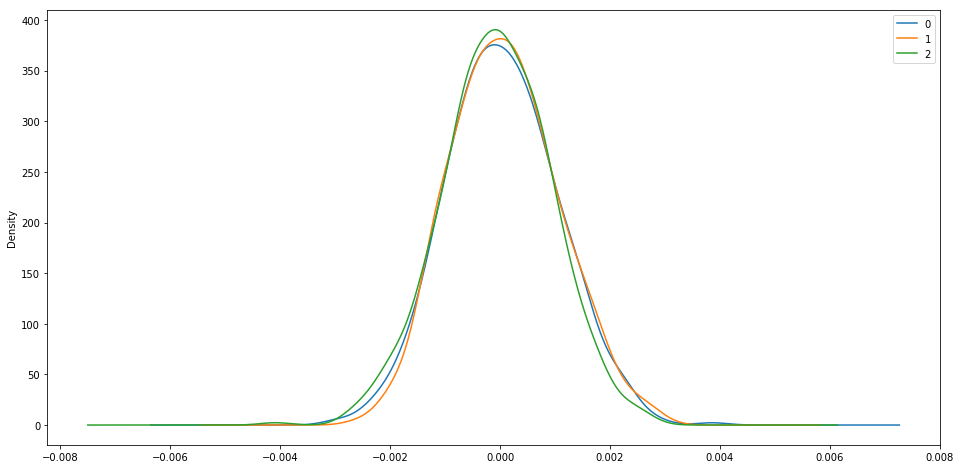

In [94]:
# projected_image = kde.resample(640)
projected_image = kde.sample(640).T
pd.DataFrame(projected_image).T.plot.kde(figsize=(16,8))

In [95]:
la_n.shape == projected_image.shape, np.any(la_n == projected_image)

(True, False)

In [96]:
projected_image_squashed = projected_image.copy()
projected_image_squashed[projected_image_squashed > 1] = 1
projected_image_squashed[projected_image_squashed < 0] = 0

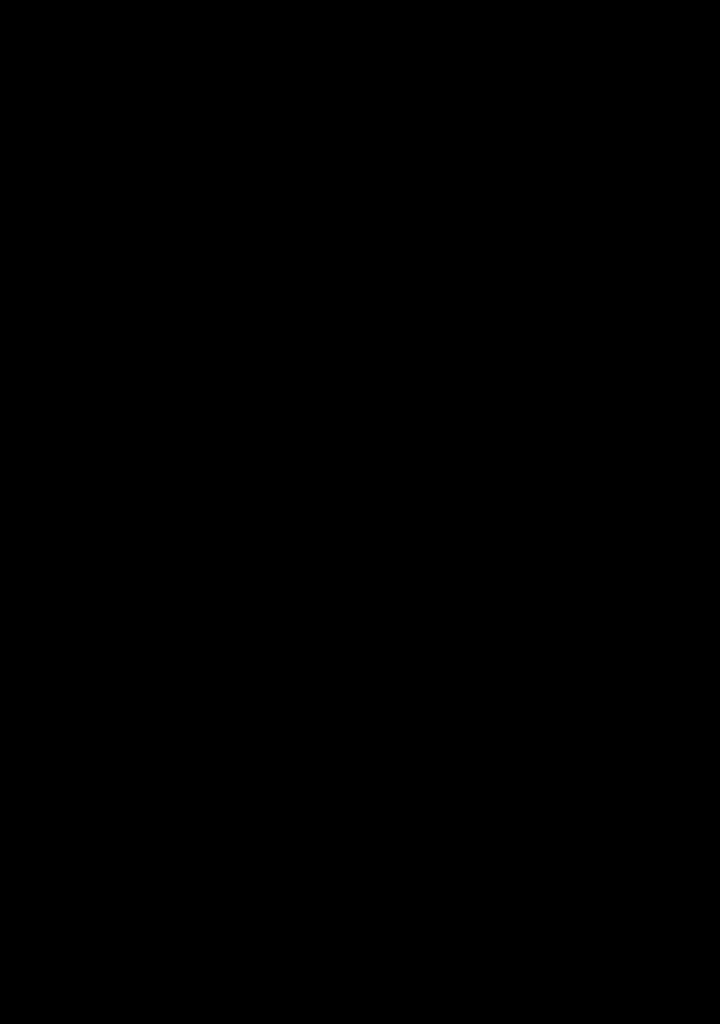

In [97]:
proj_t = torch.Tensor(projected_image_squashed)
stamp_e = torchvision.transforms.ToPILImage()(proj_t.view(3, 32, 20))
stamp_e.resize([720, 1024])

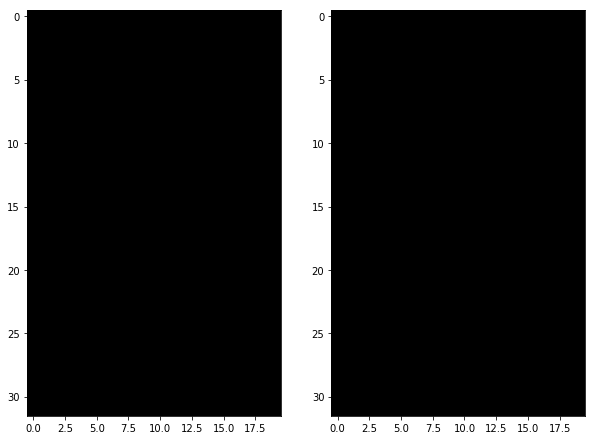

In [42]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(1,2, figsize=(10, 10))

axarr[0].imshow(stamp)
axarr[1].imshow(stamp_e)

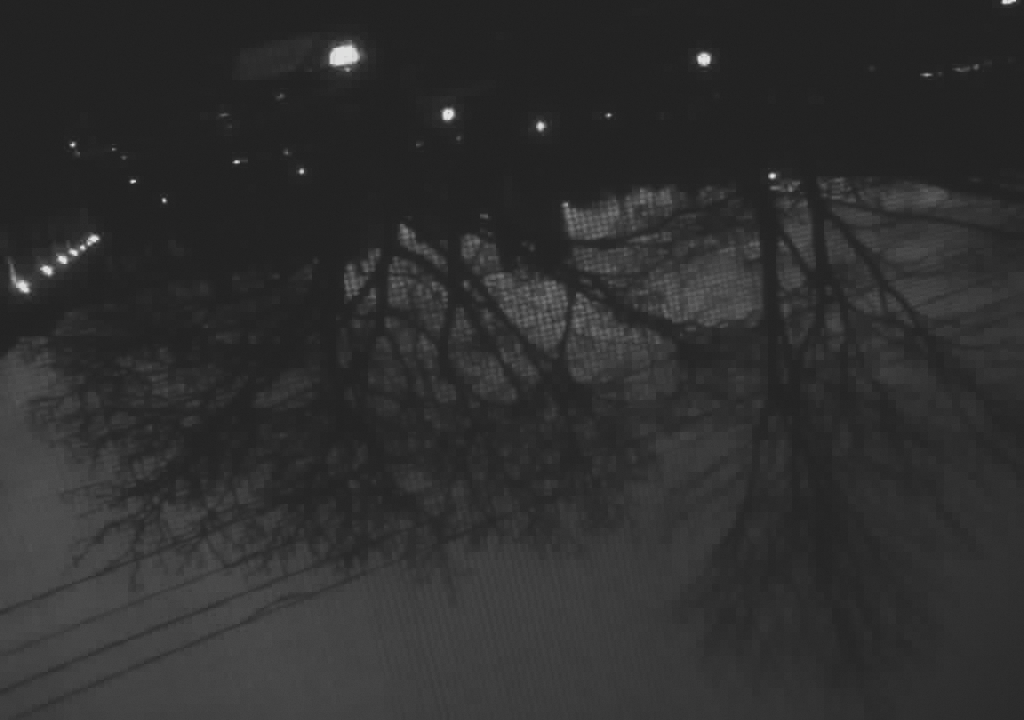

In [98]:
vv = rbm.sample_visible(proj_t)
torchvision.transforms.ToPILImage()(vv.view(3, 720, 1024))

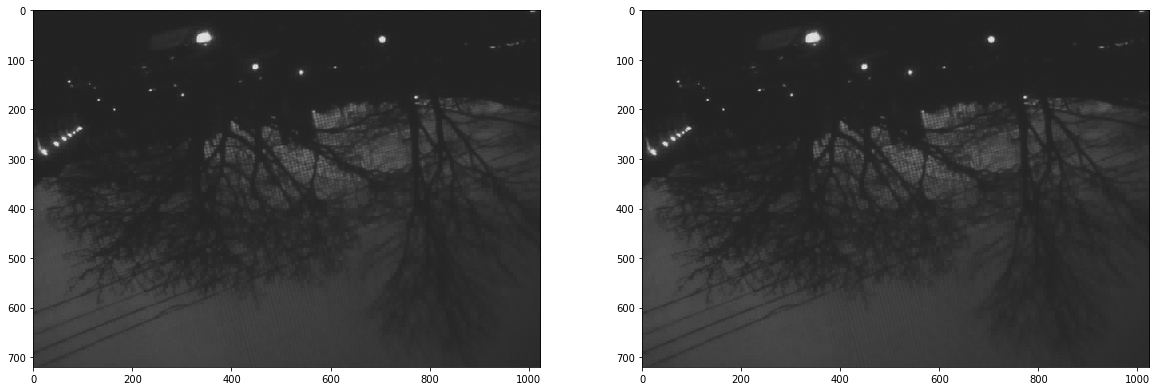

In [99]:
a = torchvision.transforms.ToPILImage()(vv.view(3, 720, 1024))
b = torchvision.transforms.ToPILImage()(v.view(3, 720, 1024))

fig, axarr = plt.subplots(1,2, figsize=(20, 10))

axarr[0].imshow(a)
axarr[1].imshow(b)

In [ ]:
# projected_image = kde.resample(640)
projected_image_sequence = kde.sample(640 * 1440).T
pd.DataFrame(projected_image_sequence).T.plot.kde(figsize=(16,8))

In [ ]:
a = projected_image_sequence[:, 0*640:1*640] 
b = projected_image_sequence[:, 1439*640:1440*640]
a.shape, b.shape
np.any(a == b)

In [ ]:
from tqdm import tnrange, tqdm_notebook

In [ ]:
for i in tnrange(1440, desc='frames'):
    p = projected_image_sequence[:, i*640:(i+1)*640]
    p[p > 1] = 1
    p[p < 0] = 0
    proj_t = torch.Tensor(p)
    pp = rbm.sample_visible(proj_t)
    ipp = torchvision.transforms.ToPILImage()(pp.view(3, 720, 1024))
    ipp.save('./image/shimmer/%05i_projected_shimmer.png' % i)

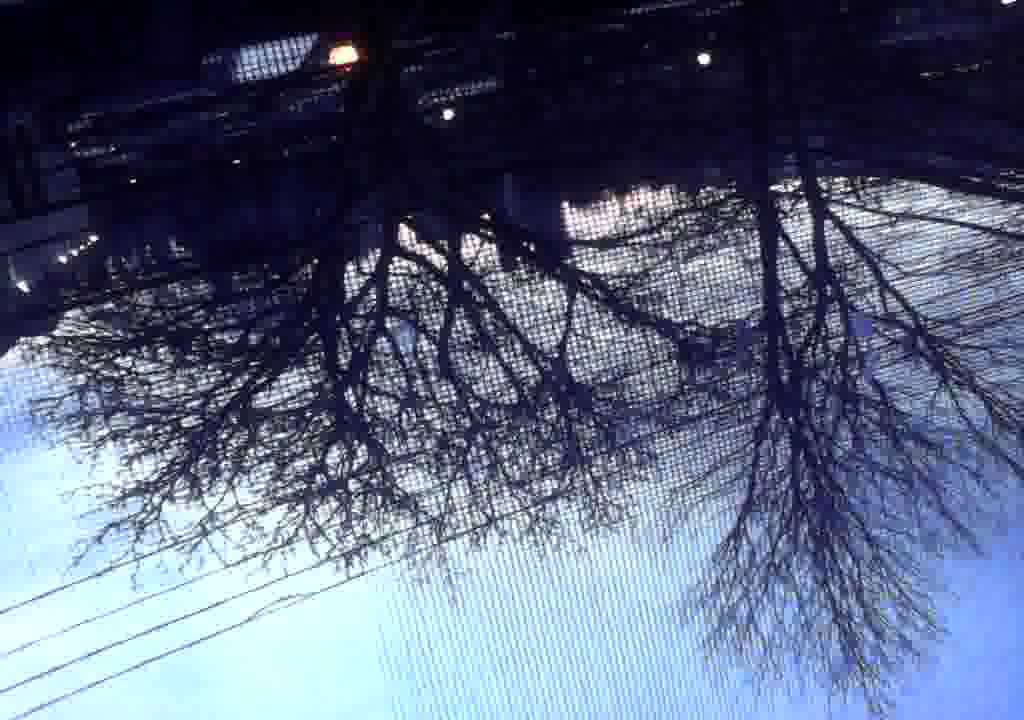

In [100]:
im = fetch_ring_im(666, r)
im

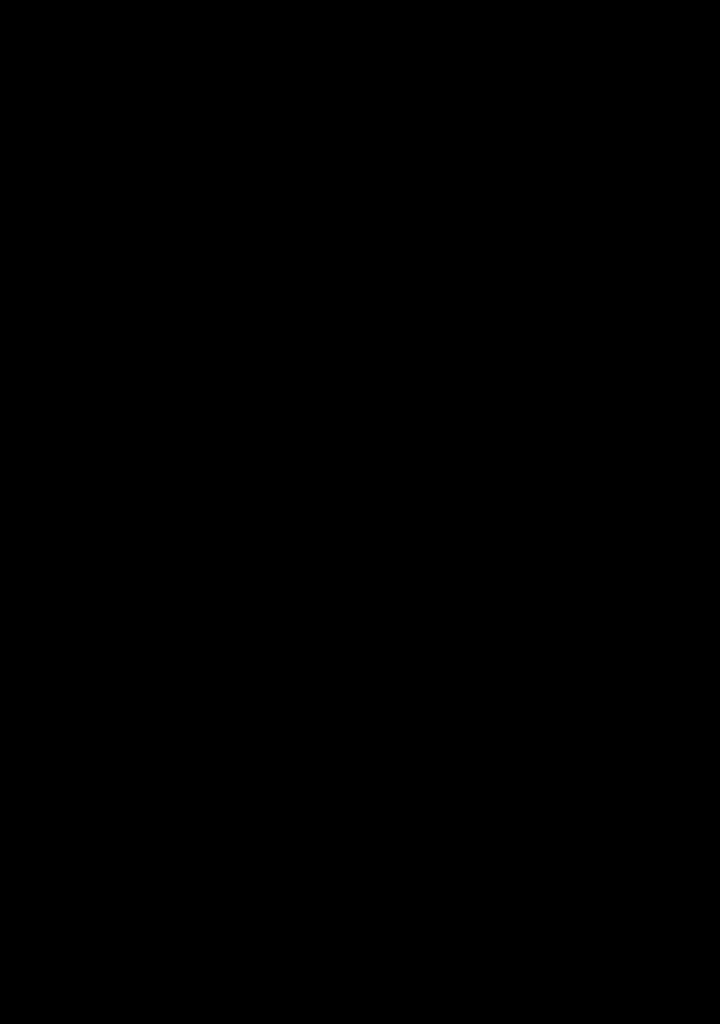

In [101]:
tens = t(im)
s = rbm.sample_hidden(tens.view(3, 720 * 1024))
stamp_e = torchvision.transforms.ToPILImage()(s.view(3, 32, 20))
stamp_e.resize([720, 1024])

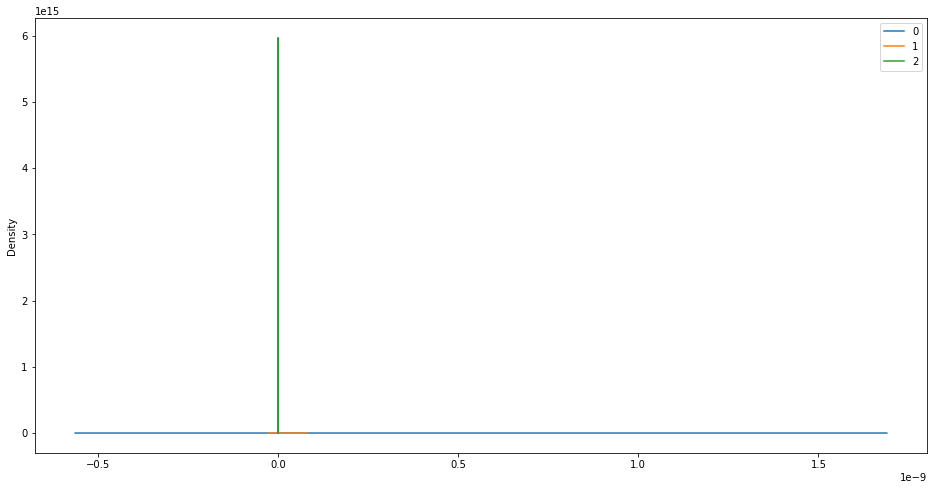

In [48]:
pd.DataFrame(s.numpy()).T.plot.kde(figsize=(16,8))

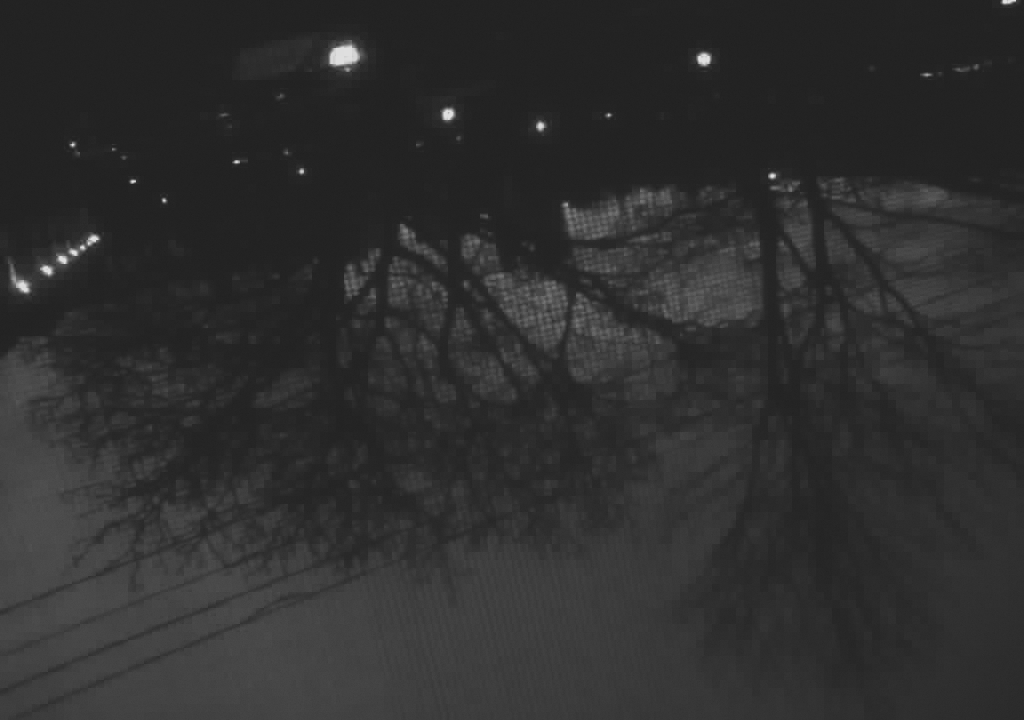

In [102]:
vvv = rbm.sample_visible(s)
torchvision.transforms.ToPILImage()(vvv.view(3, 720, 1024))

In [ ]:
inv_s = 1 - s
df = pd.DataFrame(inv_s.numpy())
p = df.T.plot.kde(figsize=(16,8))

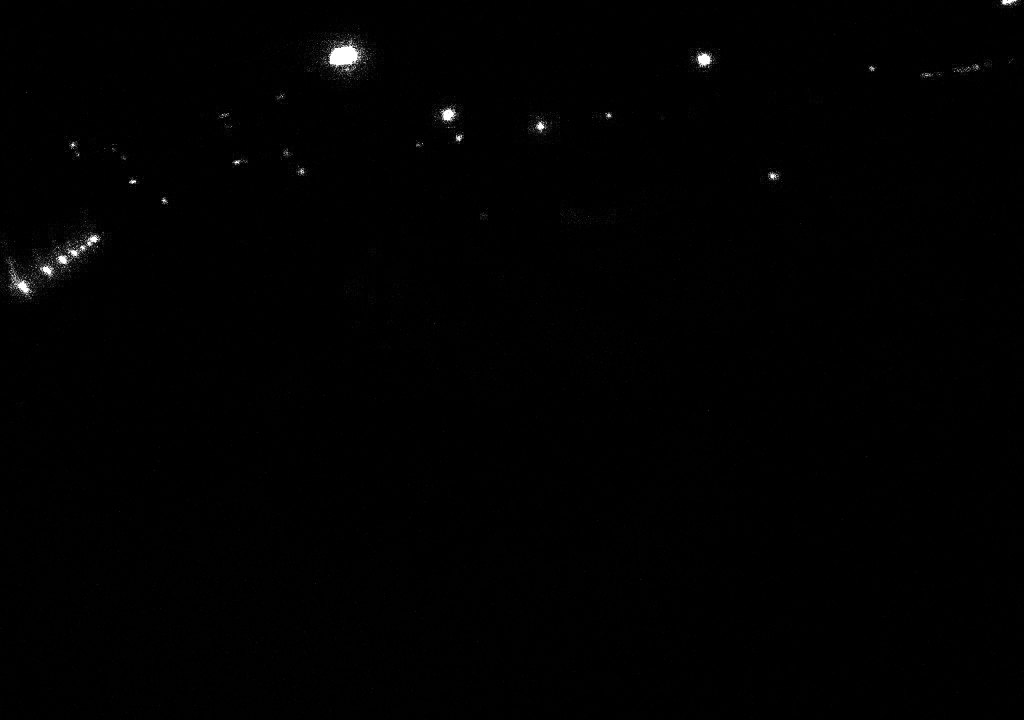

In [104]:
vvvv = rbm.sample_visible(inv_s)
torchvision.transforms.ToPILImage()(vvvv.view(3, 720, 1024))

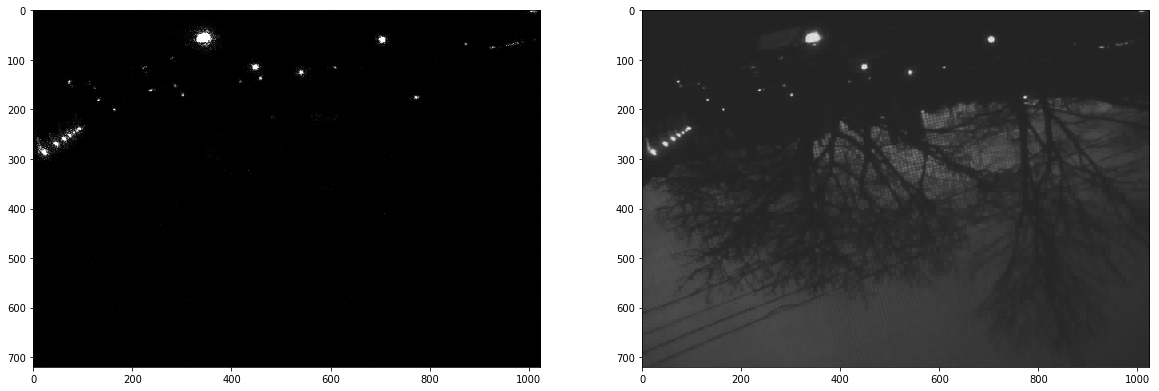

In [105]:
a = torchvision.transforms.ToPILImage()(vvvv.view(3, 720, 1024))
b = torchvision.transforms.ToPILImage()(vvv.view(3, 720, 1024)) 

fig, axarr = plt.subplots(1,2, figsize=(20, 10))

axarr[0].imshow(a)
axarr[1].imshow(b)

In [75]:
import numpy as np
x, _, _ = np.mgrid[0:1:1440j, 0:3:1, 0:640:1] 

In [76]:
from tqdm import tnrange, tqdm_notebook

In [77]:
for i in tnrange(1440, desc='frames'):
    p = x[i]
    p[p > 1] = 1
    p[p < 0] = 0
    proj_t = torch.Tensor(p)
    pp = rbm.sample_visible(proj_t)
    ipp = torchvision.transforms.ToPILImage()(pp.view(3, 720, 1024))
    ipp.save('./image/linmove/%05i_projected_linmove.png' % i)

In [203]:
frame_h = pd.Series(
    [rbm.sample_hidden(fetch_tensor_im(i, r, t)).view(3 * 640).numpy() 
     for i in tnrange(3500, 9500, 1, desc='ring')])

In [204]:
# frame_h = frame_h.apply(lambda x: x.reshape((3 * 640)))
frame_h_sh = frame_h.sample(frac=1)

In [205]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=420)
X_tsne = tsne.fit_transform(frame_h.tolist())
X_tsne_sh = tsne.fit_transform(frame_h_sh.tolist())

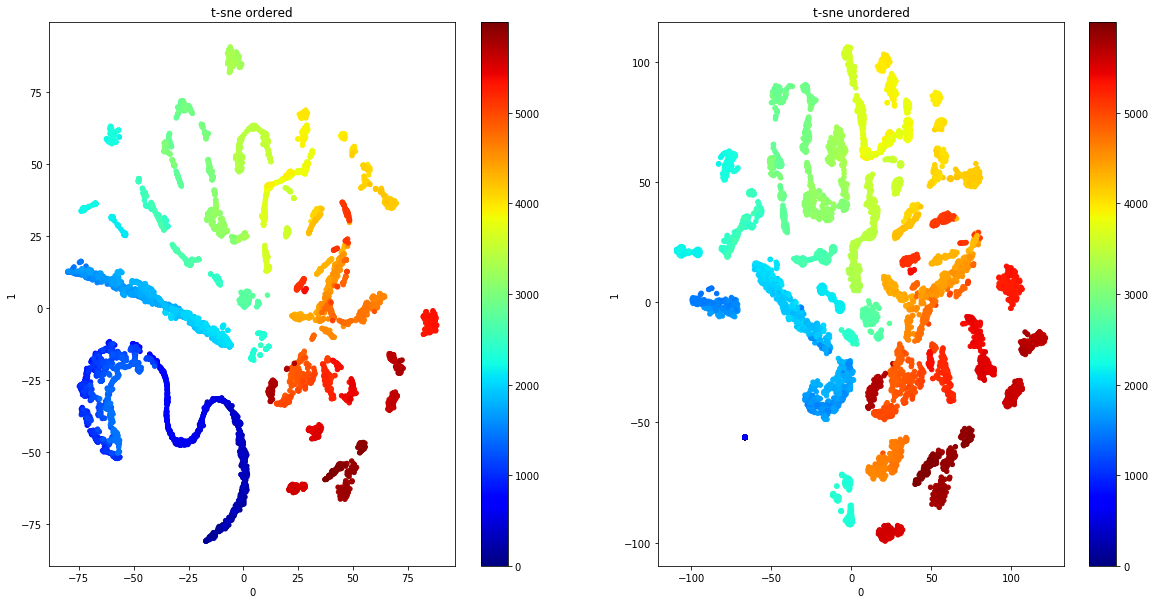

In [206]:
df = pd.DataFrame(X_tsne, index=frame_h.index)
df_sh = pd.DataFrame(X_tsne_sh, index=frame_h_sh.index)

fig, axarr = plt.subplots(1,2, figsize=(20, 10))

df.plot.scatter(0,1, c=df.index, colormap='jet', ax=axarr[0], title='t-sne ordered')
df_sh.plot.scatter(0,1, c=df_sh.index, colormap='jet', ax=axarr[1], title='t-sne unordered')

In [207]:
from scipy.spatial.distance import cdist

np.set_printoptions(precision=3)

In [221]:
# cosine on inferred hidden values
frame_h_m = np.asarray(frame_h.tolist())

distances = cdist(frame_h_m, frame_h_m, 'euclidean')
greatest_distance = np.unravel_index(distances.argmax(), distances.shape)

greatest_distance, distances[greatest_distance]

((0, 5804), 30.247316412627708)

In [222]:
df.loc[list(greatest_distance)]

0          1
0      0.152048 -48.870491
5804  46.417095 -65.470337

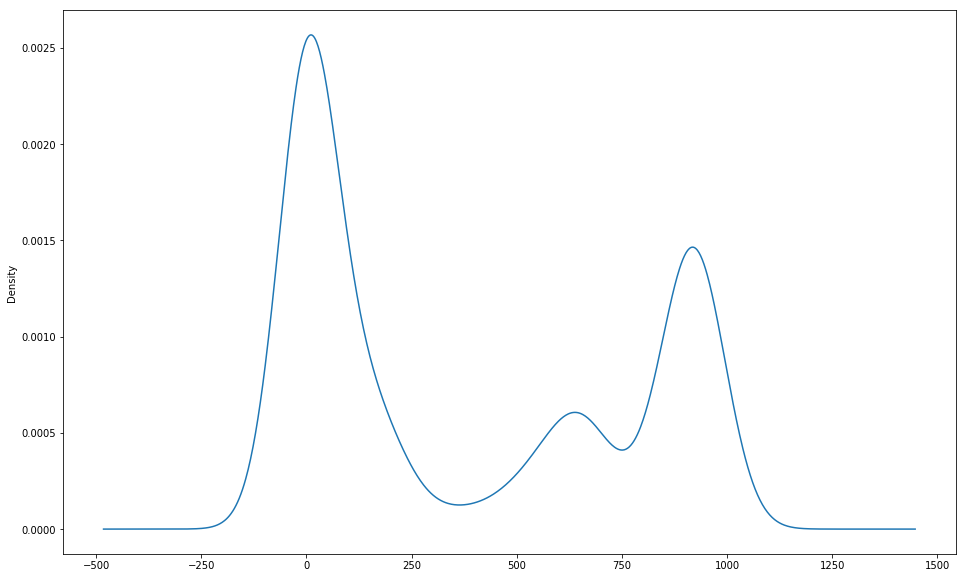

In [212]:
frame_h.apply(lambda x: x.sum()).plot.kde(figsize=(16,10))

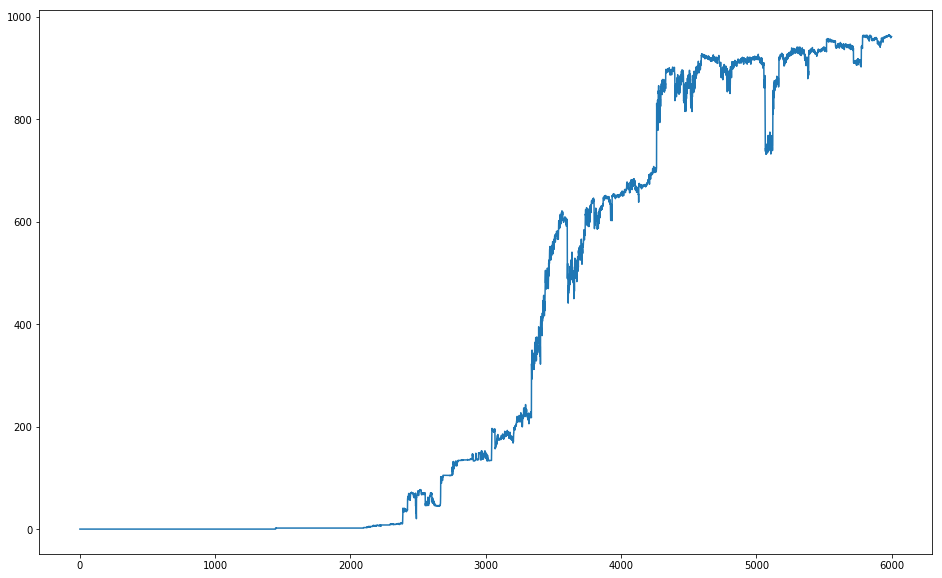

In [213]:
frame_h.apply(lambda x: x.sum()).plot.line(figsize=(16,10))

In [131]:
# # euclidean on t-SNE
# df_m = df.as_matrix()

# distances = cdist(df_m, df_m, 'euclidean')
# greatest_distance = np.unravel_index(distances.argmax(), distances.shape)

# distances, greatest_distance, distances[greatest_distance]

In [ ]:
from tqdm import tnrange, tqdm_notebook
for i in tnrange(2000, 6500, 2, desc='frames'):
    p = frame_h.loc[i]
    proj_t = torch.Tensor(p).view(3, 640)
    pp = rbm.sample_visible(proj_t)
    ipp = torchvision.transforms.ToPILImage()(pp.view(3, 720, 1024))
    ipp.save('./image/reconstruct/%05i_projected_reconstruct.png' % i)

In [136]:
greatest_distance = (3500 + 1283, 3500 + 1459)

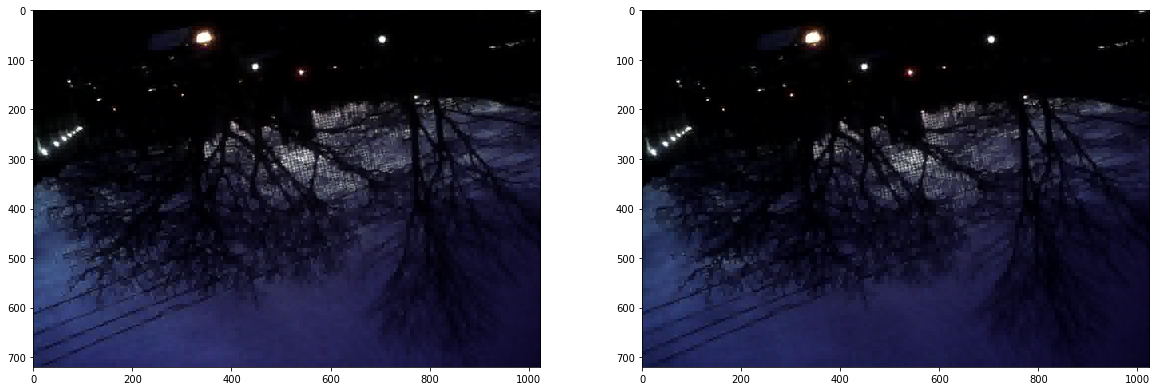

In [137]:
(a_ind, b_ind) = greatest_distance
a = fetch_ring_im(a_ind, r)
b = fetch_ring_im(b_ind, r)

fig, axarr = plt.subplots(1,2, figsize=(20, 10))

axarr[0].imshow(a)
axarr[1].imshow(b)

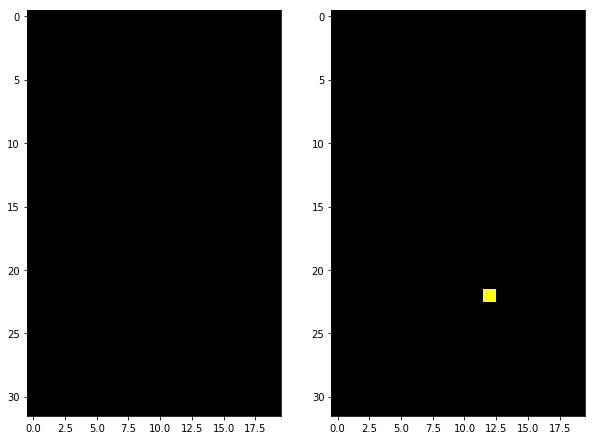

In [138]:
aaa = fetch_tensor_im(a_ind, r, t)
bbb = fetch_tensor_im(b_ind, r, t)

aa = rbm.sample_hidden(aaa.view(3, 720 * 1024))
bb = rbm.sample_hidden(bbb.view(3, 720 * 1024))

a = torchvision.transforms.ToPILImage()(aa.view(3, 32, 20))
b = torchvision.transforms.ToPILImage()(bb.view(3, 32, 20))

fig, axarr = plt.subplots(1,2, figsize=(10, 10))

axarr[0].imshow(a)
axarr[1].imshow(b)

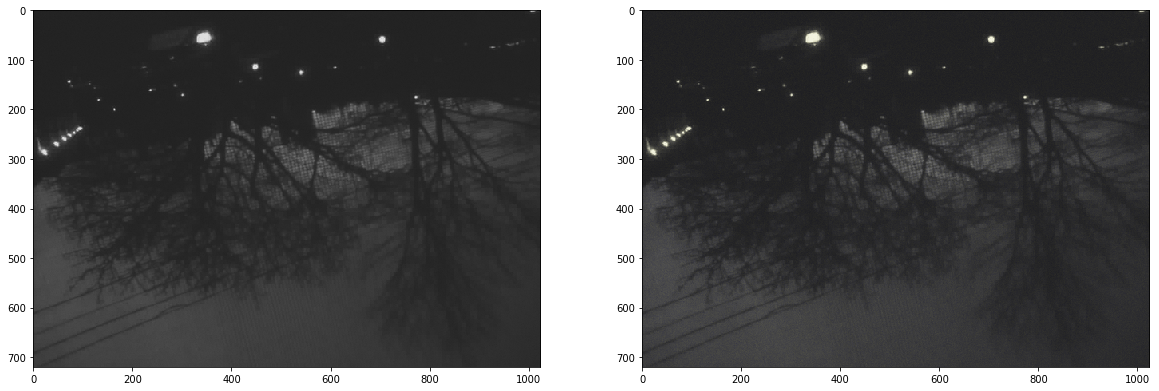

In [139]:
dd = rbm.sample_visible(aa)
ee = rbm.sample_visible(bb)

ddd = torchvision.transforms.ToPILImage()(dd.view(3, 720, 1024))
eee = torchvision.transforms.ToPILImage()(ee.view(3, 720, 1024))

fig, axarr = plt.subplots(1,2, figsize=(20, 10))

axarr[0].imshow(ddd)
axarr[1].imshow(eee)